# Simple logistic regression

This notebook follows John H McDonald's [Handbook of Biological Statistics](http://www.biostathandbook.com/simplelogistic.html) chapter on simple logistic regression.

This notebook is provided with a CC-BY-SA license.

In [1]:
import io
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import scipy.special
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

Spider data from *Suzuki et al. (2006)*:

In [2]:
data = """Grain size (mm)	Spiders
0.245	absent
0.247	absent
0.285	present
0.299	present
0.327	present
0.347	present
0.356	absent
0.36	present
0.363	absent
0.364	present
0.398	absent
0.4	present
0.409	absent
0.421	present
0.432	absent
0.473	present
0.509	present
0.529	present
0.561	absent
0.569	absent
0.594	present
0.638	present
0.656	present
0.816	present
0.853	present
0.938	present
1.036	present
1.045	present
"""
df = pd.read_table(io.StringIO(data))
df.Spiders = df.Spiders == 'present'
df.head()

,Grain size (mm),Spiders
0,0.245,False
1,0.247,False
2,0.285,True
3,0.299,True
4,0.327,True


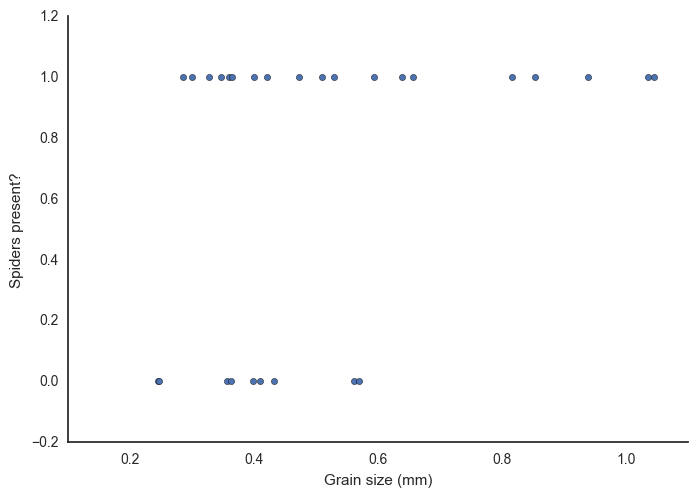

In [3]:
df.plot.scatter('Grain size (mm)', 'Spiders')
plt.ylabel('Spiders present?')
sns.despine()

I will analyse this with the *scikit-learn* package.

In [4]:
import sklearn.linear_model

scikit-learn has a logisitic regression classifier which uses regularization. To eliminate regularization, we set the regularization parameter `C` to $10^{12}$.

In [5]:
# C=1e12 is effectively no regularization - see https://github.com/scikit-learn/scikit-learn/issues/6738
clf = sklearn.linear_model.LogisticRegression(C=1e12, random_state=0)
clf.fit(df['Grain size (mm)'].reshape(-1, 1), df['Spiders'])
print(clf.intercept_, clf.coef_)

[-1.64748882] [[ 5.12118846]]


This is in agreement with the equation John reports:
$$
probability of spider presence = \frac{e^{-1.6476+5.1215(grain \; size)}}{(1+e^{-1.6476+5.1215(grain \; size)}}
$$

In [6]:
def plot_log_reg(x, y, data, clf, xmin=None, xmax=None, alpha=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.scatter(data[x], data[y], color='black', zorder=20, alpha=alpha)
    if xmin is None:
        xmin = x.min()
    if xmax is None:
        xmax = x.max()
    X_test = np.linspace(xmin, xmax, 300)

    loss = scipy.special.expit(X_test * clf.coef_ + clf.intercept_).ravel()
    ax.plot(X_test, loss, linewidth=3)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    fig.tight_layout()
    sns.despine()
    return fig, ax

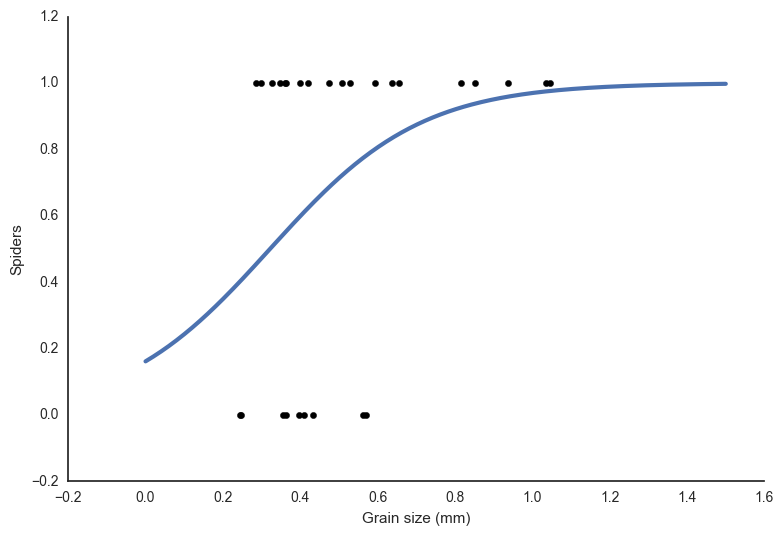

In [7]:
plot_log_reg(x='Grain size (mm)', y='Spiders', data=df, clf=clf, xmin=0, xmax=1.5);

# Hypothesis testing

To test if *Grain size* is a significant factor, we use the [**likelihood ratio test**](https://en.wikipedia.org/wiki/Logistic_regression#Evaluating_goodness_of_fit).

We calculate the likelihood of the model with the grain size (the alternative model):

In [8]:
def log_reg_null_model(X, y):
    X_ = np.zeros_like(X)
    if X_.ndim == 1:
        X_ = X_.reshape(-1, 1)
    clf = sklearn.linear_model.LogisticRegression(C=1e12)
    clf.fit(X_, y)
    return clf

clf0 = log_reg_null_model(df['Grain size (mm)'], df['Spiders'])

The likelihood ratio test operates by calculating the test statistic $D$ from the likelihoods of the null and alternative models:
$$
D = -2 \log{ \frac{L(H_0)}{L(H_1)} }
$$
The test statistic is then approximately chisquare distributed.

*scikit-learn* has a log-loss function that can help us do that. 
The log-loss is defined as the negative log-likelihood, so we can rewrite:
$$
D = 2 (-\log{L(H_0)} + \log{L(H_1)}) \Rightarrow \\
D = 2 (logloss(H_0) - logloss(H_1))
$$

In [9]:
import sklearn.metrics

In [10]:
def log_reg_lik_ratio_test(X, Y, clf0, clf1, df=1):
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    y_prob0 = clf0.predict_proba(X)
    loss0 = sklearn.metrics.log_loss(Y, y_prob0, normalize=False)
    y_prob1 = clf1.predict_proba(X)
    loss1 = sklearn.metrics.log_loss(Y, y_prob1, normalize=False)
    D = 2 * (loss0 - loss1)
    return scipy.stats.distributions.chi2.sf(D, df=df)

In [11]:
log_reg_lik_ratio_test(df['Grain size (mm)'], df['Spiders'].astype(np.float64), clf0, clf)

0.033243767135570736

John indeed reports 0.033.

Note that the log-loss calculation in equivalent to:

In [12]:
_ = clf.predict_proba(df['Grain size (mm)'].reshape(-1, 1))
df['prob_absent'], df['prob_present'] = _[:,0], _[:,1]
lik = df.loc[df['Spiders'], 'prob_present'].prod() * df.loc[~df['Spiders'], 'prob_absent'].prod()
print(
    -np.log(lik), 
    sklearn.metrics.log_loss(
        df['Spiders'], 
        clf.predict_proba(df['Grain size (mm)'].reshape(-1, 1)), 
        normalize=False
    )
)

15.3157739197 15.3157739197


## Second example

In [13]:
data = """Location	Latitude	Mpi90	Mpi100	p, Mpi100
Port Townsend, WA	48.1	47	139	0.748
Neskowin, OR	45.2	177	241	0.577
Siuslaw R., OR	44	1087	1183	0.521
Umpqua R., OR	43.7	187	175	0.483
Coos Bay, OR	43.5	397	671	0.628
San Francisco, CA	37.8	40	14	0.259
Carmel, CA	36.6	39	17	0.304
Santa Barbara, CA	34.3	30	0	0
"""
df = pd.read_table(io.StringIO(data))
df.head()

,Location,Latitude,Mpi90,Mpi100,"p, Mpi100"
0,"Port Townsend, WA",48.1,47,139,0.748
1,"Neskowin, OR",45.2,177,241,0.577
2,"Siuslaw R., OR",44.0,1087,1183,0.521
3,"Umpqua R., OR",43.7,187,175,0.483
4,"Coos Bay, OR",43.5,397,671,0.628


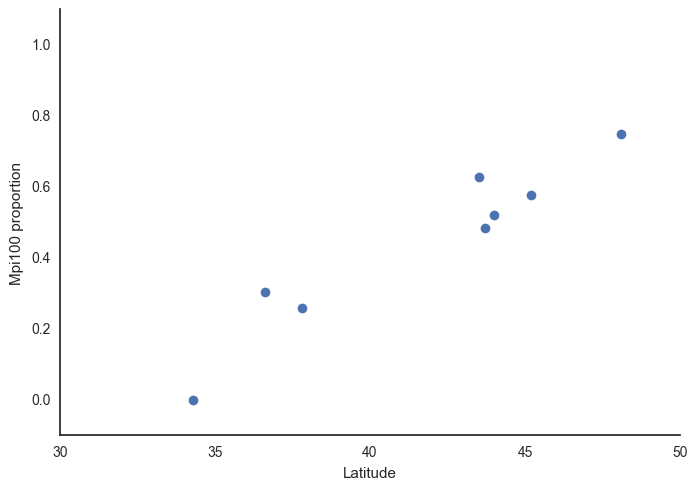

In [14]:
df.sort_values('Latitude').plot('Latitude', 'p, Mpi100', ls='', marker='o')
plt.ylabel('Mpi100 proportion')
plt.legend().set_visible(False)
plt.xlim(30, 50)
plt.ylim(-0.1, 1.1)
sns.despine()

In [15]:
rows = []
for i, row in df.iterrows():
    for _ in range(row['Mpi90']):
        rows.append({'Location':row['Location'], 'Latitude': row['Latitude'], 'Allele': 0})
    for _ in range(row['Mpi100']):
        rows.append({'Location':row['Location'], 'Latitude': row['Latitude'], 'Allele': 1})
raw_df = pd.DataFrame(rows)
raw_df.head()

,Allele,Latitude,Location
0,0,48.1,"Port Townsend, WA"
1,0,48.1,"Port Townsend, WA"
2,0,48.1,"Port Townsend, WA"
3,0,48.1,"Port Townsend, WA"
4,0,48.1,"Port Townsend, WA"


In [16]:
clf = sklearn.linear_model.LogisticRegression(C=1e12, random_state=0)
clf.fit(raw_df['Latitude'].reshape(-1, 1), raw_df['Allele'])
print(clf.intercept_, clf.coef_)

[-7.59881547] [[ 0.17754715]]


which is very close to McDonald's intercept of -7.6469 and slope of 0.1786.

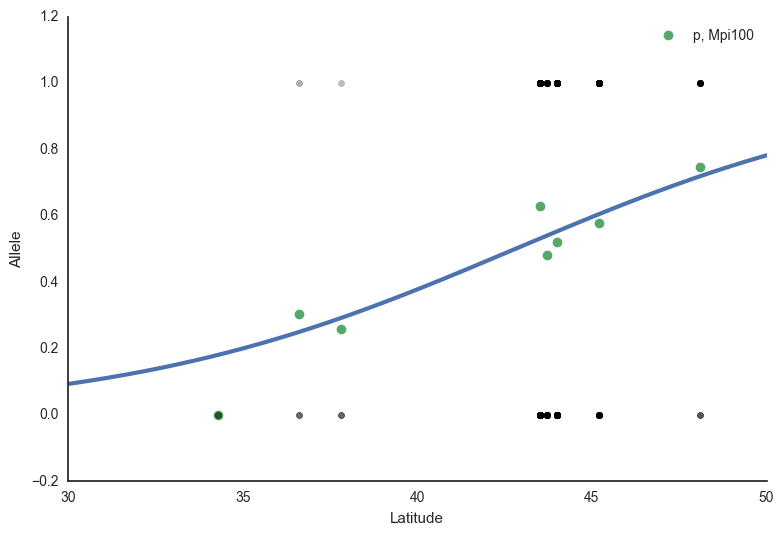

In [17]:
fig, ax = plot_log_reg(x='Latitude', y='Allele', data=raw_df, clf=clf, xmin=30, xmax=50, alpha=0.02)
df.sort_values('Latitude').plot('Latitude', 'p, Mpi100', ls='', marker='o', ax=ax)

In [18]:
clf0 = log_reg_null_model(raw_df['Latitude'], raw_df['Allele'])
print(clf0.intercept_, clf0.coef_)

[ 0.19685284] [[ 0.]]


In [19]:
log_reg_lik_ratio_test(raw_df['Latitude'], raw_df['Allele'], clf0, clf)

7.0572187317602719e-20

# Multiple logistic regression

Now following the [chapter of the same name](http://www.biostathandbook.com/multiplelogistic.html) in the same book.

Here is an example using the data on bird introductions to New Zealand.

In [25]:
data="""
Cyg_olor 1 1520  9600 1.21 1 12 2  6   1 0 0 1  6 29
Cyg_atra 1 1250  5000 0.56 1  0 1  6   1 0 0 1 10 85
Cer_nova 1  870  3360 0.07 1  0 1  4   1 0 0 1  3 8
Ans_caer 0  720  2517 1.1  3 12 2  3.8 1 0 0 1  1 10
Ans_anse 0  820  3170 3.45 3  0 1  5.9 1 0 0 1  2 7
Bra_cana 1  770  4390 2.96 2  0 1  5.9 1 0 0 1 10 60
Bra_sand 0   50  1930 0.01 1  0 1  4   2 0 0 0  1 2
Alo_aegy 0  680  2040 2.71 1  . 2  8.5 1 0 0 1  1 8
Ana_plat 1  570  1020 9.01 2  6 2 12.6 1 0 0 1 17 1539
Ana_acut 0  580   910 7.9  3  6 2  8.3 1 0 0 1  3 102
Ana_pene 0  480   590 4.33 3  0 1  8.7 1 0 0 1  5 32
Aix_spon 0  470   539 1.04 3 12 2 13.5 2 1 0 1  5 10
Ayt_feri 0  450   940 2.17 3 12 2  9.5 1 0 0 1  3 9
Ayt_fuli 0  435   684 4.81 3 12 2 10.1 1 0 0 1  2 5
Ore_pict 0  275   230 0.31 1  3 1  9.5 1 1 1 0  9 398
Lop_cali 1  256   162 0.24 1  3 1 14.2 2 0 0 0 15 1420
Col_virg 1  230   170 0.77 1  3 1 13.7 1 0 0 0 17 1156
Ale_grae 1  330   501 2.23 1  3 1 15.5 1 0 1 0 15 362
Ale_rufa 0  330   439 0.22 1  3 2 11.2 2 0 0 0  2 20
Per_perd 0  300   386 2.4  1  3 1 14.6 1 0 1 0 24 676
Cot_pect 0  182    95 0.33 3  . 2  7.5 1 0 0 0  3 .
Cot_aust 1  180    95 0.69 2 12 2 11   1 0 0 1 11 601
Lop_nyct 0  800  1150 0.28 1 12 2  5   1 1 1 0  4 6
Pha_colc 1  710   850 1.25 1 12 2 11.8 1 1 0 0 27 244
Syr_reev 0  750   949 0.2  1 12 2  9.5 1 1 1 0  2 9
Tet_tetr 0  470   900 4.17 1  3 1  7.9 1 1 1 0  2 13
Lag_lago 0  390   517 7.29 1  0 1  7.5 1 1 1 0  2 4
Ped_phas 0  440   815 1.83 1  3 1 12.3 1 1 0 0  1 22
Tym_cupi 0  435   770 0.26 1  4 1 12   1 0 0 0  3 57
Van_vane 0  300   226 3.93 2 12 3  3.8 1 0 0 0  8 124
Plu_squa 0  285   318 1.67 3 12 3  4   1 0 0 1  2 3
Pte_alch 0  350   225 1.21 2  0 1  2.5 2 0 0 0  1 8
Pha_chal 0  320   350 0.6  1 12 2  2   2 1 0 0  8 42
Ocy_loph 0  330   205 0.76 1  0 1  2   7 1 0 1  4 23
Leu_mela 0  372     . 0.07 1 12 2  2   1 1 0 0  6 34
Ath_noct 1  220   176 4.84 1 12 3  3.6 1 1 0 0  7 221
Tyt_alba 0  340   298 8.9  2  0 3  5.7 2 1 0 0  1 7
Dac_nova 1  460   382 0.34 1 12 3  2   1 1 0 0  7 21
Lul_arbo 0  150  32.1 1.78 2  4 2  3.9 2 1 0 0  1 5
Ala_arve 1  185  38.9 5.19 2 12 2  3.7 3 0 0 0 11 391
Pru_modu 1  145  20.5 1.95 2 12 2  3.4 2 1 0 0 14 245
Eri_rebe 0  140  15.8 2.31 2 12 2  5   2 1 0 0 11 123
Lus_mega 0  161  19.4 1.88 3 12 2  4.7 2 1 0 0  4 7
Tur_meru 1  255  82.6 3.3  2 12 2  3.8 3 1 0 0 16 596
Tur_phil 1  230  67.3 4.84 2 12 2  4.7 2 1 0 0 12 343
Syl_comm 0  140  12.8 3.39 3 12 2  4.6 2 1 0 0  1 2
Syl_atri 0  142  17.5 2.43 2  5 2  4.6 1 1 0 0  1 5
Man_mela 0  180     . 0.04 1 12 3  1.9 5 1 0 0  1 2
Man_mela 0  265    59 0.25 1 12 2  2.6 . 1 0 0  1 80
Gra_cyan 0  275   128 0.83 1 12 3  3   2 1 0 1  1 .
Gym_tibi 1  400   380 0.82 1 12 3  4   1 1 0 0 15 448
Cor_mone 0  335   203 3.4  2 12 2  4.5 1 1 0 0  2 3
Cor_frug 1  400   425 3.73 1 12 2  3.6 1 1 0 0 10 182
Stu_vulg 1  222  79.8 3.33 2  6 2  4.8 2 1 0 0 14 653
Acr_tris 1  230 111.3 0.56 1 12 2  3.7 1 1 0 0  5 88
Pas_dome 1  149  28.8 6.5  1  6 2  3.9 3 1 0 0 12 416
Pas_mont 0  133    22 6.8  1  6 2  4.7 3 1 0 0  3 14
Aeg_temp 0  120     . 0.17 1  6 2  4.7 3 1 0 0  3 14
Emb_gutt 0  120    19 0.15 1  4 1  5   3 0 0 0  4 112
Poe_gutt 0  100  12.4 0.75 1  4 1  4.7 3 0 0 0  1 12
Lon_punc 0  110  13.5 1.06 1  0 1  5   3 0 0 0  1 8
Lon_cast 0  100     . 0.13 1  4 1  5   . 0 0 1  4 45
Pad_oryz 0  160     . 0.09 1  0 1  5   . 0 0 0  2 6
Fri_coel 1  160  23.5 2.61 2 12 2  4.9 2 1 0 0 17 449
Fri_mont 0  146  21.4 3.09 3 10 2  6   . 1 0 0  7 121
Car_chlo 1  147    29 2.09 2  7 2  4.8 2 1 0 0  6 65
Car_spin 0  117    12 2.09 3  3 1  4   2 1 0 0  3 54
Car_card 1  120  15.5 2.85 2  4 1  4.4 3 1 0 0 14 626
Aca_flam 1  115  11.5 5.54 2  6 1  5   2 1 0 0 10 607
Aca_ﬂavi 0  133    17 1.67 2  0 1  5   3 0 1 0  3 61
Aca_cann 0  136  18.5 2.52 2  6 1  4.7 2 1 0 0 12 209
Pyr_pyrr 0  142  23.5 3.57 1  4 1  4   3 1 0 0  2 .
Emb_citr 1  160  28.2 4.11 2  8 2  3.3 3 1 0 0 14 656
Emb_hort 0  163  21.6 2.75 3 12 2  5   1 0 0 0  1 6
Emb_cirl 1  160  23.6 0.62 1 12 2  3.5 2 1 0 0  3 29
Emb_scho 0  150  20.7 5.42 1 12 2  5.1 2 0 0 1  2 9
Pir_rubr 0  170    31 0.55 3 12 2  4   . 1 0 0  1 2
Age_phoe 0  210  36.9 2    2  8 2  3.7 1 0 0 1  1 2
Stu_negl 0  225 106.5 1.2  2 12 2  4.8 2 0 0 0  1 2
"""
cols = 'species status length mass range migr insect diet clutch broods wood upland water release indiv'.split()
ind_vars = cols[2:]
df = pd.read_table(io.StringIO(data), names=cols, header=None, delim_whitespace=True, na_values=['.'])
df.dropna(inplace=True)
y_true = df['status']
X = df[ind_vars]
df.head()

,species,status,length,mass,range,migr,insect,diet,clutch,broods,wood,upland,water,release,indiv
0,Cyg_olor,1,1520,9600.0,1.21,1,12.0,2,6.0,1.0,0,0,1,6,29.0
1,Cyg_atra,1,1250,5000.0,0.56,1,0.0,1,6.0,1.0,0,0,1,10,85.0
2,Cer_nova,1,870,3360.0,0.07,1,0.0,1,4.0,1.0,0,0,1,3,8.0
3,Ans_caer,0,720,2517.0,1.10,3,12.0,2,3.8,1.0,0,0,1,1,10.0
4,Ans_anse,0,820,3170.0,3.45,3,0.0,1,5.9,1.0,0,0,1,2,7.0


In [26]:
def log_reg_fit(X, y):
    clf = sklearn.linear_model.LogisticRegression(C=1e12)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    clf.fit(X, y)
    return clf

In [32]:
pvals_threshold = 0.05
clf0 = log_reg_null_model(y_true, y_true)
included_vars = []
excluded_vars = ind_vars.copy()

while excluded_vars:
    selected_var, pval = None, 1
    for var in excluded_vars:
        X_ = X[included_vars + [var]]
        clf = log_reg_fit(X_, y_true)
        pval_ = log_reg_lik_ratio_test(X_, y_true, clf0, clf)
        if pval_ < pval:
            selected_var, pval = var, pval_
    if pval < pvals_threshold:
        print("Adding {} with p-value {:.2g}".format(selected_var, pval))
        included_vars.append(selected_var)
        excluded_vars.remove(selected_var)
        X_ = X[included_vars].copy()
        X_['placeholder'] = 0
        clf0 = log_reg_fit(X_, y_true)
    else:
        break

Adding release with p-value 4.9e-09
Adding upland with p-value 0.0044
Adding migr with p-value 0.011


I get a similar result to the one presented by John, but I need a smaller P value threshold (I used 0.05 instead of 0.15). With 0.15 I get several more variables. Not sure why... Maybe the P value calculation in the book is using Wald test (used by SAS in the example given in the book), whereas I'm using the likelihood ratio test (which I believe is a better choice here).